<a href="https://colab.research.google.com/github/KukovecRok/AlexNet_inaccurate_using_NiaPy/blob/main/AlexNetDiplomskaColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predpogoj - mount gDrive - za import

In [45]:
# Nujno potrebno za dostop do datotek iz gDrivea
from google.colab import drive
drive.mount('/content/gdrive') # Preverjanje pristnosti.. 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [46]:
# Potrebni importi
import os
import torch
import torch.nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torchvision.utils as utils
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import argparse
import PIL.Image
import pandas as pd
import glob
from pathlib import Path
import time
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt
import numpy
from scipy import stats

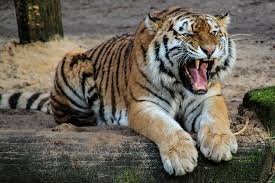

In [ ]:
from IPython.display import Image, display
display(Image('/content/gdrive/MyDrive/Colab Notebooks/slike/tiger.jpg')) # Slika iz https://phys.org/news/2019-11-indian-authorities-exaggerated-tiger.html

## Prikaz random slike iz množice

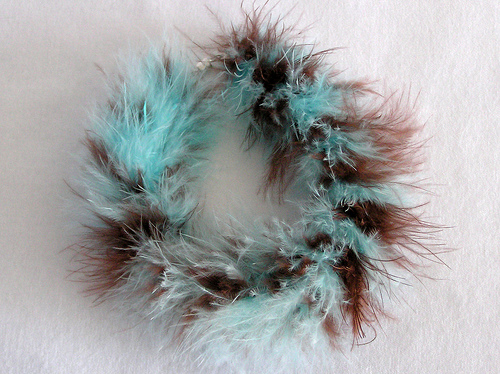

In [ ]:
import random, os
# Prikaz nakljucne slike
path = "/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/"
random_file = random.choice([
    x for x in os.listdir(path)
    if os.path.isfile(os.path.join(path, x))
])
Image('/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/'+random_file)

## Funkcija napovejSlike - za import

In [47]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval()

def napovejSlike(slika, alexnet):
   # Obdelava velikosti slike
    data_transforms = transforms.Compose([
        transforms.Resize((224,224)),       # Nastavi velikost sičic 224x224
        transforms.ToTensor(),              # Input na Tensorjev format
        transforms.Normalize( # Normalizacija
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )])
    # Odpiranje slik
    transformed_img = data_transforms(slika) # Klicanje funkcije za obdelavo velikosti slik(e)
    batch_img = torch.unsqueeze(transformed_img, 0)
    
    output = alexnet(batch_img)

    sorted, indices = torch.sort(output, descending=True)
    percentage = F.softmax(output, dim=1)[0] * 100.0 
    
    return indices, percentage

In [ ]:
# Izboljsana napoved - vse slike v mapi
CasZacetek = time.time()

df = None
if df is not None:
    df = df.drop(['SlicicaNo.','Dejansko','Napovedano','PoNiaPy','Tocnost'], axis=1, errors='ignore')

#images = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/slike/*.jpg")
images = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/*.JPEG")
podatki = []
for image in images:
   with open(image, 'rb') as file:
        img = PIL.Image.open(file)
        indices, percentage = napovejSlike(img, alexnet)
        i = 0
        with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
            classes = [i.strip() for i in labels.readlines()]

            # Top 5 razredov po verjetnosti napovedi
            results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]

            podatki.append({
                'Slicica No.': (Path(file.name).stem)[20:],
                'Napovedano':  results[0][0],
                'PoNiaPy' : ['Sledi'],
                'Tocnost' : results[0][1],
                'ImeDatoteke' : (Path(file.name).stem + ".JPEG")
            })

            #print("\nTop 5 napovedanih razredov")
            #for i in range(5):
                #print('{}: {:.4f}%'.format(results[i][0], results[i][1]))
            print('\nNaš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')

df = pd.DataFrame(data=podatki)
df.sort_values(by='Tocnost', ascending=False, inplace=True)

CasKonec = time.time()
trajanje = CasKonec - CasZacetek
print("Trajanje: ", trajanje)
# Merjenje časa - CPU 71 sekund ; GPU 301; TPU 338 - nekaj ni ok..

NameError: ignored

## Slike iz ILSVRC2010
Model se je na njih izkazal za zelo uspešnega

Tukaj imamo tabelo imen datotek ter kategorij, v katero spadajo

In [ ]:
df1 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/MatLab/ID,Ime,Kategorija.csv", sep=";", index_col=0) 
df1.sample(5) 

,ImeDatoteke,Kategorija
ID_Kategorija,,
330,ILSVRC2010_val_00035385.JPEG,polyp
872,ILSVRC2010_val_00018329.JPEG,stone wall
226,ILSVRC2010_val_00009252.JPEG,"palm, palm tree"
38,ILSVRC2010_val_00046099.JPEG,"chard, Swiss chard, spinach beet, leaf beet"
737,ILSVRC2010_val_00003804.JPEG,basketball


## Skupne kategorije
* 634
* Kategorije v preseku, ki jih zna napovedatovat tale AlexNet in slike iz ILSVRC2010
* Validacijska množica ni uporabljena za učenje, rezultati bodo verjetno višji kot pri testni, kar je v mojem primeru tudi smiselno
* Velika točnost pred NiaPy, nato pa nekaj popolnoma drugega za "enako" sliko..

In [ ]:
df2 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/MatLab/BothKategorije.csv", sep=";", index_col=0) 
print(len(df2))

634


## Predpripravljena tabela 
* stolpec NiaPy se bo napolnil kasneje

In [ ]:
# Združevanje za dejanske kategorije
df = df.merge(df1, how='inner', on='ImeDatoteke')
# Brisanje praznih (v df1 je 50.000 vrstic - celotna _val množica slik)
df.dropna(inplace=True)
# Združevanje iz dataframera samo skupnih kategorij --> Inner join odstrani vse primerke, ki jih naš model ne zna napovedat
df = df.merge(df2, how='inner', on='Kategorija')
# Preimenovanje stolpca
df = df.rename(columns={"Kategorija": "Dejanska_kategorija"})
# Zamenjava vrstnega reda stolpcev
df = df[['Slicica No.','Dejanska_kategorija','Napovedano','PoNiaPy','Tocnost','ImeDatoteke']]
df.sort_values(by=['Tocnost'], ascending=False).head(10)
# Dolžina df = 636, kar se sklada s številom različnih imen datotek, katerih kategorije zna napovedat
# V driveu je 1000 slik, vseh kategorij je ~1600, naš AlexNet jih zna napovedat ~2/3 = 1000. 
# Slike so randomly vendar konsistentno poimenovane, ~2/3 * 1000 = ~ 640, torej bo najverjetneje držalo

,Slicica No.,Dejanska_kategorija,Napovedano,PoNiaPy,Tocnost,ImeDatoteke
0,472,"chambered nautilus, pearly nautilus, nautilus","chambered nautilus, pearly nautilus, nautilus",[Sledi],100.000000,ILSVRC2010_val_00000472.JPEG
2,857,baseball,baseball,[Sledi],99.999985,ILSVRC2010_val_00000857.JPEG
4,041,"odometer, hodometer, mileometer, milometer","odometer, hodometer, mileometer, milometer",[Sledi],99.999763,ILSVRC2010_val_00000041.JPEG
6,733,"maze, labyrinth","maze, labyrinth",[Sledi],99.998917,ILSVRC2010_val_00000733.JPEG
10,116,manhole cover,manhole cover,[Sledi],99.998734,ILSVRC2010_val_00000116.JPEG
13,680,shopping basket,shopping basket,[Sledi],99.998451,ILSVRC2010_val_00000680.JPEG
16,620,"pool table, billiard table, snooker table","pool table, billiard table, snooker table",[Sledi],99.997139,ILSVRC2010_val_00000620.JPEG
19,362,"upright, upright piano","upright, upright piano",[Sledi],99.996796,ILSVRC2010_val_00000362.JPEG
21,990,"giant panda, panda, panda bear, coon bear, Ail...","giant panda, panda, panda bear, coon bear, Ail...",[Sledi],99.995758,ILSVRC2010_val_00000990.JPEG
24,371,"bobsled, bobsleigh, bob","bobsled, bobsleigh, bob",[Sledi],99.994896,ILSVRC2010_val_00000371.JPEG


In [ ]:
col_one_list = df['ImeDatoteke'].tolist()
col_one_list.sort()
# Število različnih imen datotek = 637 - Nekatere kategorije so podvojene (različne slike spadajo v enako kategorijo)
len(col_one_list)

637

## Tabela napačno napovedanih

In [ ]:
dfNapacni = df[~df['Dejanska_kategorija'].isin(df['Napovedano'])]
dfNapacni.sort_values(by=['Tocnost'], ascending=False).head(10)

,Slicica No.,Dejanska_kategorija,Napovedano,PoNiaPy,Tocnost,ImeDatoteke
262,977,otter,badger,[Sledi],90.782722,ILSVRC2010_val_00000977.JPEG
300,855,"bakery, bakeshop, bakehouse",trifle,[Sledi],87.583473,ILSVRC2010_val_00000855.JPEG
305,415,trimaran,catamaran,[Sledi],86.632591,ILSVRC2010_val_00000415.JPEG
312,193,screwdriver,nail,[Sledi],85.336327,ILSVRC2010_val_00000193.JPEG
329,704,"green lizard, Lacerta viridis","American chameleon, anole, Anolis carolinensis",[Sledi],82.166130,ILSVRC2010_val_00000704.JPEG
337,155,partridge,"ruffed grouse, partridge, Bonasa umbellus",[Sledi],79.790657,ILSVRC2010_val_00000155.JPEG
343,344,cliff dwelling,"sloth bear, Melursus ursinus, Ursus ursinus",[Sledi],78.339386,ILSVRC2010_val_00000344.JPEG
397,353,"artichoke, globe artichoke",cardoon,[Sledi],70.422081,ILSVRC2010_val_00000353.JPEG
416,975,tiger cat,"tiger, Panthera tigris",[Sledi],65.720955,ILSVRC2010_val_00000975.JPEG
263,728,otter,"red-backed sandpiper, dunlin, Erolia alpina",[Sledi],65.469406,ILSVRC2010_val_00000728.JPEG


## Tabela pravilno napovedanih

In [ ]:
dfPravilni = df[df['Dejanska_kategorija'].isin(df['Napovedano'])] #dfPravilni = df.loc[df['Dejanska_kategorija'] == df['Napovedano']] # Drugačna sintaksa za isto stvar
dfPravilni.sort_values(by=['Tocnost'], ascending=False).head(10)

,Slicica No.,Dejanska_kategorija,Napovedano,PoNiaPy,Tocnost,ImeDatoteke
0,472,"chambered nautilus, pearly nautilus, nautilus","chambered nautilus, pearly nautilus, nautilus",[Sledi],100.000000,ILSVRC2010_val_00000472.JPEG
2,857,baseball,baseball,[Sledi],99.999985,ILSVRC2010_val_00000857.JPEG
4,041,"odometer, hodometer, mileometer, milometer","odometer, hodometer, mileometer, milometer",[Sledi],99.999763,ILSVRC2010_val_00000041.JPEG
6,733,"maze, labyrinth","maze, labyrinth",[Sledi],99.998917,ILSVRC2010_val_00000733.JPEG
10,116,manhole cover,manhole cover,[Sledi],99.998734,ILSVRC2010_val_00000116.JPEG
13,680,shopping basket,shopping basket,[Sledi],99.998451,ILSVRC2010_val_00000680.JPEG
16,620,"pool table, billiard table, snooker table","pool table, billiard table, snooker table",[Sledi],99.997139,ILSVRC2010_val_00000620.JPEG
19,362,"upright, upright piano","upright, upright piano",[Sledi],99.996796,ILSVRC2010_val_00000362.JPEG
21,990,"giant panda, panda, panda bear, coon bear, Ail...","giant panda, panda, panda bear, coon bear, Ail...",[Sledi],99.995758,ILSVRC2010_val_00000990.JPEG
24,371,"bobsled, bobsleigh, bob","bobsled, bobsleigh, bob",[Sledi],99.994896,ILSVRC2010_val_00000371.JPEG


## Statistika nad ILSVRC2010_val_\*\*\*\*****.JPEG

In [ ]:
pravilno_napovedani = len(df.index) - len(dfNapacni.index)
print("Vsi napovedani: " + str(len(df.index)) + "\nPravilno napovedani: " + str(pravilno_napovedani) +"\nNapacno napovedani: " + str(len(dfNapacni.index)))
Tocnost = (pravilno_napovedani / len(df.index)* 100)
print("Tocnost: %.4f"% Tocnost+"%")

Vsi napovedani: 637
Pravilno napovedani: 535
Napacno napovedani: 102
Tocnost: 83.9874%


In [ ]:
# Napoved 1 slike
slika = 'strawberries100-53.jpg'
with open('/content/gdrive/MyDrive/Colab Notebooks/slike/'+slika, 'rb') as file:
    img = PIL.Image.open(file)
    indices, percentage = napovejSlike(img, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
            classes = [i.strip() for i in labels.readlines()]

            # Top 5 razredov po verjetnosti napovedi
            results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
            print('\nNaš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')


Naš napovedan razred: strawberry 
Algoritem to trdi z zagotovostvjo 99.99%


# NiaPy - za import
* install

In [48]:
!pip install NiaPy==2.0.0rc12
!pip install -U scikit-image

Requirement already up-to-date: scikit-image in /usr/local/lib/python3.7/dist-packages (0.18.1)



Prva ideja je po vzoru TestBenchmark.py, ustvarit array podoben "iskanje = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]"
* Pretvorba slike v 1d array
* Standardizacija (vsaka vrednost v arrayu / 255)
* Izvajanje NiaPy
* Pretvorba napovedanih vredenosti nazaj v vrednosti med 1 - 255 ( * 255)
* Pretvorba 1d arraya v sliko
* Prikaz slike, primerjava..


# Funkcije - za import

In [49]:
import cv2
from google.colab.patches import cv2_imshow

def imgTO1d(img):
    oblika = img.shape
    img = img.reshape(-1)
    testko = np.divide(img, 255) 
    return oblika, testko

def imgFROM1d(testko, oblika):
    testkoDva = numpy.multiply(testko, 255)  
    testkoDva = asarray(testkoDva)
    testkoDva = testkoDva.reshape(oblika)
    return testkoDva

def napovedInPrikaz(PIL_image, alexnet):
    indices, percentage = napovejSlike(PIL_image, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]
        results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
        napoved = ('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')
    return napoved

def napovedString(PIL_image, alexnet):
    indices, percentage = napovejSlike(PIL_image, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]
        results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
        napoved = str(results[0][0])
    return napoved

def BenchMark (originalSlika, solution, alexnet, oblika):
  rezultat = 1

  solutionSpremenjen = imgFROM1d(solution, oblika)
  PIL_image_solution = PIL.Image.fromarray(np.uint8(solutionSpremenjen)).convert('RGB')

  indices, percentage = napovejSlike(PIL_image_solution, alexnet)
  with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
      classes = [i.strip() for i in labels.readlines()]
      results = [(classes[i], percentage[i].item()) for i in indices[0][:1000]]

      # Not baseball
      for i in range(len(results)):
          if (str(results[i][0]) == "baseball"):
              rezultat *= (1 - (results[i][1] / 100) )
              #print("najden baseball:  ", rezultat)

  # SSIM
  rezultat *= ssim(originalSlika, solutionSpremenjen, multichannel=True)

  # Top other
  if (str(results[0][0]) != "baseball"):
    rezultat *= ( results[0][1] / 100 )
  else:
    rezultat *= ( results[1][1] / 100 )

  return rezultat

def BenchMarkIzpisuj (originalSlika, solution, alexnet, oblika):
  rezultat = 1
  ssim_result = 0
  ntbsbl = 0
  topother = 0

  solutionSpremenjen = imgFROM1d(solution, oblika)
  PIL_image_solution = PIL.Image.fromarray(np.uint8(solutionSpremenjen)).convert('RGB')

  indices, percentage = napovejSlike(PIL_image_solution, alexnet)
  with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
      classes = [i.strip() for i in labels.readlines()]
      results = [(classes[i], percentage[i].item()) for i in indices[0][:1000]]

      # Not baseball
      for i in range(len(results)):
          if (str(results[i][0]) == "baseball"):
              ntbsbl = (1 - (results[i][1] / 100) )
              rezultat *= (1 - (results[i][1] / 100) )
              #print("najden baseball:  ", rezultat)

  # SSIM
  rezultat *= ssim(originalSlika, solutionSpremenjen, multichannel=True)
  ssim_result = ssim(originalSlika, solutionSpremenjen, multichannel=True)

  # Top other
  if (str(results[0][0]) != "baseball"):
    rezultat *= ( results[0][1] / 100 )
    topother = ( results[0][1] / 100 )
  else:
    rezultat *= ( results[1][1] / 100 )
    topother = ( results[0][1] / 100 )
  print("ssim:   " + str(ssim_result) +  "      ntbsbl: " +  str(ntbsbl) +  "      topother:   " +  str(topother))

  return rezultat

# Funkcije - metrike kakovosti slike - za import

In [6]:
def MSE(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def compare_images(imageA, imageB):
    # compute the mean squared error and structural similarity
    # index for the images
    m = MSE(imageA, imageB)
    s = ssim(imageA, imageB, multichannel=True)
    # setup the figure
    fig = plt.figure(" ")
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
    # show the images
    plt.show()


def PSNR(original, recreated): 
    mse = np.mean((original - recreated) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

from sklearn.metrics import mean_absolute_error

# ŠE ENA možnost PSNR, knjiznica sk_image
#from skimage.metrics import peak_signal_noise_ratio as sk_PSNR 
#print(sk_PSNR(originalSlika, odResitev, data_range=255 ))
#mse_error = MSE(originalSlika, odResitev)

## Trenutna slika 60*60 baseball
* samo 1
* bejzbol.jpeg ( original : "ILSVRC2010_val_00000857.JPEG" )
* pomanjašana v 60x60

Ali je sploh smiselno nad sliko izvajat pretvorbe, ki ji same po sebi nižajo prepoznavnost?

In [ ]:
# Napoved 1 slike
#slika = 'ILSVRC2010_val_00000857.JPEG'
slika = 'nautlius80-60.JPEG'

#with open('/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/'+slika, 'rb') as file:
with open('/content/gdrive/MyDrive/Colab Notebooks/slike/'+slika, 'rb') as file:
    img = PIL.Image.open(file)
    indices, percentage = napovejSlike(img, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
            classes = [i.strip() for i in labels.readlines()]

            # Top 5 razredov po verjetnosti napovedi
            results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
            print('\nNaš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')


Naš napovedan razred: chambered nautilus, pearly nautilus, nautilus 
Algoritem to trdi z zagotovostvjo 100.00%


# Poizkusi z NiaPy
## Napoved po 3 Pixle v NiaPy - default B.M.

In [ ]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

class TestBenchmark(Benchmark):

    def __init__(self, iskanje):
        self.Lower = 0
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanje = iskanje

    def function(self):
        def evaluate(D, solution):
            # print(f'D: {D}')
            # print(f'solution: {solution}')

            razlika = 0
            for i in range(D):
                razlika = razlika + abs(iskanje[i] - solution[i])

            return razlika

        return evaluate

if __name__ == "__main__":

    originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/tiger.jpg')
    oblika, iskanjeSlika = imgTO1d(originalSlika)

    algoritem = ParticleSwarmAlgorithm(NP=20)  

    n = len(iskanjeSlika)
    rangeFor = (int(n / 9))

    resitevTiger = np.empty(n, dtype=object)
    iskanje = np.empty(9, dtype=object)
    
    for i in range(rangeFor):
        i *= 9
        for j in range (9):
            iskanje[j] = iskanjeSlika[i+j]
    
        benchm = TestBenchmark(iskanje=iskanje)
        task = StoppingTask(D=len(iskanje),
                            nFES=50,
                            optType=OptimizationType.MINIMIZATION,
                            benchmark=benchm)

        resitev, fitness = algoritem.run(task=task)
        for j in range (9):
            resitevTiger[i+j] = resitev[j]

    print("ISKANJE: ", iskanje)
    print("resitev: ", resitev)
    print("fitness: ", fitness)
    # Celotna slika --> 1d array pri NP=10.000 in nFES=100.000: "Vaša seja se je zrušila, ko ste porabili ves razpoložljivi RAM. ", rezultat pa zanič, priložen v GitHubu

ISKANJE:  [0.10588235294117647 0.24705882352941178 0.12941176470588237
 0.14901960784313725 0.3215686274509804 0.1607843137254902
 0.2901960784313726 0.4627450980392157 0.30980392156862746]
resitev:  [0.31007909 0.34709627 0.62792256 0.01237383 0.32786906 0.59609625
 0.25926059 0.43739971 0.33018752]
fitness:  1.4576676113648386


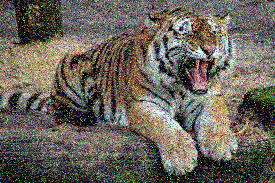

Naš napovedan razred: tiger cat 
Algoritem to trdi z zagotovostvjo 26.99%


In [ ]:
Tiger = imgFROM1d(resitevTiger, oblika)
cv2_imshow(Tiger)

PIL_image = PIL.Image.fromarray(np.uint8(Tiger)).convert('RGB')

indices, percentage = napovejSlike(PIL_image, alexnet)
with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
    classes = [i.strip() for i in labels.readlines()]

    # Top 5 razredov po verjetnosti napovedi
    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    print('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')

 ##  Napovedovanje samo dela slike v NiaPy - default B.M.

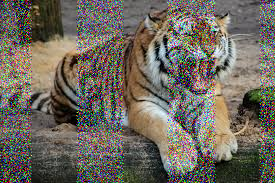

Naš napovedan razred: picket fence, paling 
Algoritem to trdi z zagotovostvjo 9.43%


In [ ]:
# Spreminjanje samo dela slike?
originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/tiger.jpg')

oblika, iskanjeSlika = imgTO1d(originalSlika)

algoritem = ParticleSwarmAlgorithm(NP=10)  

n = len(iskanjeSlika)
rangeFor = (int(n / 9))

resitevTigerDva = np.empty(n, dtype=object)
iskanje = np.empty(9, dtype=object)
    
for i in range(rangeFor):
    i *= 9
    for j in range (9):
        iskanje[j] = iskanjeSlika[i+j]
    if ( ( (i % 275) > 0) & ( (i % 275) < 90) | ( (i % 275) < 275) & ( (i % 275) > 225) ):
        benchm = TestBenchmark(iskanje=iskanje)
        task = StoppingTask(D=len(iskanje),
                          nFES=20,
                          optType=OptimizationType.MINIMIZATION,
                          benchmark=benchm)

        resitev, fitness = algoritem.run(task=task)

        for j in range (9):
            resitevTigerDva[i+j] = resitev[j]
    else:
        for j in range (9):
            resitevTigerDva[i+j] = iskanjeSlika[i+j]

TigerDva = imgFROM1d(resitevTigerDva, oblika)
cv2_imshow(TigerDva)

PIL_image = PIL.Image.fromarray(np.uint8(TigerDva)).convert('RGB')

indices, percentage = napovejSlike(PIL_image, alexnet)
with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
    classes = [i.strip() for i in labels.readlines()]

    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    print('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')

## Napoved Pixel po Pixel v NiaPy - default B.M.

Povprečna razlika v barvi piksla:  12.653314136674789


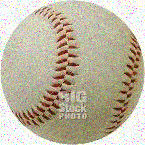

Naš napovedan razred: baseball 
Algoritem to trdi z zagotovostvjo 94.38%


In [ ]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

class TestBenchmark(Benchmark):

    def __init__(self, iskanje):
        self.Lower = 0
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanje = iskanje

    def function(self):
        def evaluate(D, solution):
            # print(f'D: {D}')
            # print(f'solution: {solution}')

            razlika = 0

            for i in range(D):
                razlika = razlika + abs(iskanje[i] - solution[i])
            
            return razlika

        return evaluate

if __name__ == "__main__":
    originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol.JPEG')

    oblika, iskanjeSlika = imgTO1d(originalSlika)

    algoritem = ParticleSwarmAlgorithm(NP=20)  

    n = len(iskanjeSlika)
    rangeFor = (int(n / 3))

    resitevTigerTri = np.empty(n, dtype=object)
    iskanje = np.empty(3, dtype=object)
    fitnes = 0
    
    for i in range(rangeFor):
        i *= 3
        for j in range (3):
            iskanje[j] = iskanjeSlika[i+j]
    
        benchm = TestBenchmark(iskanje=iskanje)
        task = StoppingTask(D=len(iskanje),
                            nFES=40,
                            optType=OptimizationType.MINIMIZATION,
                            benchmark=benchm)

        resitev, fitness = algoritem.run(task=task)
        fitnes += fitness
        for j in range (3):
            resitevTigerTri[i+j] = resitev[j]

    fitnes = (fitnes/n)*255

    print("Povprečna razlika v barvi piksla: ", fitnes)

    TigerTri = imgFROM1d(resitevTigerTri, oblika)
    cv2_imshow(TigerTri)

    PIL_image = PIL.Image.fromarray(np.uint8(TigerTri)).convert('RGB')

    indices, percentage = napovejSlike(PIL_image, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]

        results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
        print('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')
    # Celotna slika --> 1d array pri NP=10.000 in nFES=100.000: "Vaša seja se je zrušila, ko ste porabili ves razpoložljivi RAM. ", rezultat pa zanič, priložen v GitHubu

In [ ]:
kompresija = '/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol60-60.JPEG'
img = PIL.Image.open(kompresija)

indices, percentage = napovejSlike(img, alexnet)
with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
    classes = [i.strip() for i in labels.readlines()]

    # Top 5 razredov po verjetnosti napovedi
    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    print('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')

Naš napovedan razred: baseball 
Algoritem to trdi z zagotovostvjo 97.37%


Povprečna razlika v barvi piksla:  81.94661535922793


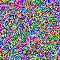

Naš napovedan razred: dishrag, dishcloth 
Algoritem to trdi z zagotovostvjo 14.51%


In [ ]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

class TestBenchmark(Benchmark):

    def __init__(self, iskanje):
        self.Lower = 0
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanje = iskanje

    def function(self):
        def evaluate(D, solution):
            # print(f'D: {D}')
            # print(f'solution: {solution}')

            razlika = 0

            for i in range(D):
                razlika = razlika + abs(iskanje[i] - solution[i])
            razlika = (razlika / D )
            
            return razlika

        return evaluate

if __name__ == "__main__":

    #originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/tiger.jpg')
    originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol60-60.JPEG')

    oblika, iskanje = imgTO1d(originalSlika)

    algoritem = ParticleSwarmAlgorithm(NP=100)  
    
    benchm = TestBenchmark(iskanje=iskanje)
    task = StoppingTask(D=len(iskanje),
                        nFES=1000,
                        optType=OptimizationType.MINIMIZATION,
                        benchmark=benchm)

    resitev, fitness = algoritem.run(task=task)

    print("Povprečna razlika v barvi piksla: ", (fitness*255))

    TigerTri = imgFROM1d(resitev, oblika)
    cv2_imshow(TigerTri)

    PIL_image = PIL.Image.fromarray(np.uint8(TigerTri)).convert('RGB')

    indices, percentage = napovejSlike(PIL_image, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]

        results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
        print('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')
    # Celotna slika --> 1d array pri NP=10.000 in nFES=100.000: "Vaša seja se je zrušila, ko ste porabili ves razpoložljivi RAM. ", rezultat pa zanič, priložen v GitHubu

## Napoved - MINIMIZATION

Najden boljsi:   0.2450438160168944
Najden boljsi:   0.1863060470761363
Najden boljsi:   0.16951168241509093
Najden boljsi:   0.15864397500158195
Najden boljsi:   0.13375335195500854
Povprečna razlika v barvi piksla:  34.10710474852718


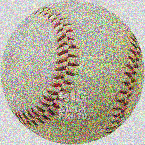

Naš napovedan razred: dishrag, dishcloth 
Algoritem to trdi z zagotovostvjo 38.50%


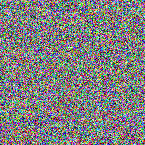

Naš napovedan razred: poncho 
Algoritem to trdi z zagotovostvjo 27.06%


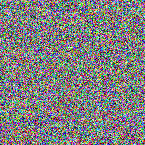

Naš napovedan razred: poncho 
Algoritem to trdi z zagotovostvjo 27.06%


In [ ]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

class TestBenchmark(Benchmark):

    def __init__(self, iskanje, odResitev, prvic, alexnet, benchmarkPrejsnji, najboljsiNiaPY):
        self.Lower = 0
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanje = iskanje
        self.odResitev = odResitev
        self.prvic = prvic
        self.benchmarkPrejsnji = benchmarkPrejsnji
        self.najboljsiNiaPY = najboljsiNiaPY

        self.alexnet = alexnet
    def function(self):
        def evaluate(D, solution):
            razlika = 0 # BenchMark rezultat
            treshold = 0.3 # Dovoljeno odstopanje pikslov

            global prvic # Sprememba na False
            global odResitev # Spreminjanje arraya - vzamemo napovedane RGB vrednosti, ki so (približno) blizu realnim
            global najboljsiNiaPY # Shrani vrednost najboljše NiaPy napovedi
            global benchmarkPrejsnji # Shrani B.M. za primerjavo napovedi

            for i in range(D):
                razlika = razlika + abs(iskanje[i] - solution[i])

                # Ce smo zagnali prvic, array "odResitev napolnimo z vrednostmi, ne glede na to, kaj so
                if (prvic): 
                    odResitev.fill(0) # Napolnimo z niclami, saj ne napove celotnega arraya --> NoneType error
                    odResitev[i] = solution[i] # Prepisemo napovedane vrednosti
                    prvic = False

                # Če je absolutna razlika piksla manjsa od  dovoljene, ga zamenjamo, vse ostale pobijemo
                if (abs(iskanje[i] - solution[i]) < treshold):
                    odResitev[i] = solution[i]

            razlika = ( razlika / D ) # Delimo absolutno razliko pikslov s številom pisklov - DOBIMO VREDNOST MED 0 - 1
            
            spreminjanjeArraya = imgFROM1d(odResitev, oblika)
            PIL_image = PIL.Image.fromarray(np.uint8(spreminjanjeArraya)).convert('RGB')

            indices, percentage = napovejSlike(PIL_image, alexnet)
            with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
                classes = [i.strip() for i in labels.readlines()]

                results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
                if (str(results[0][0]) != "baseball"):
                  razlika *=  (1 - (results[0][1] / 100)) # Napoved AlexNet - DOBIMO VREDNOST MED 0 - 1
                  #print(razlika)
                else:
                  razlika = 1

            if (benchmarkPrejsnji > razlika):
                najboljsiNiaPY = solution
                benchmarkPrejsnji = razlika
                print("Najden boljsi:  ", benchmarkPrejsnji)

            return razlika
        
        return evaluate

if __name__ == "__main__":

    originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol.JPEG') # odpiranje - branje slike

    oblika, iskanje = imgTO1d(originalSlika) # Pretvorba slike v 1d array + njena oblika (x,y,3)

    algoritem = ParticleSwarmAlgorithm(NP=100)

    odResitev = np.empty(len(iskanje), dtype=object) # Prazen array dolžine iskanega - Malo pomoči NiaPy
    najboljsiNiaPY = np.empty(len(iskanje), dtype=object) # Prazen array dolžine iskanega - Najboljši NiaPy približek

    benchmarkPrejsnji = 1 # Primerjava BenchMarkov med iteracijami - če je slabši, prepišemo "najboljsiNiaPY" in "benchmarkPrejsnji"

    prvic = True # Preverjanje, če je algo zagnan prvič

    benchm = TestBenchmark(iskanje=iskanje, odResitev=odResitev, prvic=prvic, alexnet=alexnet, benchmarkPrejsnji=benchmarkPrejsnji, najboljsiNiaPY=najboljsiNiaPY)
    task = StoppingTask(D=len(iskanje),
                        nFES=100,
                        optType=OptimizationType.MINIMIZATION,
                        benchmark=benchm)

    resitev, fitness = algoritem.run(task=task)

    ##################################################################
    # Različni poizkusi benchmarkov in spreminjanja arrayev - PRIKAZ #
    ##################################################################

    print("Povprečna razlika v barvi piksla: ", (fitness*255)) # Butasta metoda razlike pisklov - DOPOLNI

    # Prikaz in napoved zadnjega "odResitev"
    spreminjanjeArraya = imgFROM1d(odResitev, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(spreminjanjeArraya) # Prikaz slike
    PIL_image = PIL.Image.fromarray(np.uint8(spreminjanjeArraya)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(PIL_image, alexnet)) # Izpis napovedi AlexNet

    # Prikaz in napoved najboljse napovedi NiaPy
    najboljsiNiaPY = imgFROM1d(najboljsiNiaPY, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(najboljsiNiaPY) # Prikaz slike
    najboljsiNiaPY_image = PIL.Image.fromarray(np.uint8(najboljsiNiaPY)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(najboljsiNiaPY_image, alexnet)) # Izpis napovedi AlexNet

    # Prikaz koncnega - zadnjega outputa NiaPy 
    resitev = imgFROM1d(resitev, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(resitev) # Prikaz slike
    resitev_image = PIL.Image.fromarray(np.uint8(resitev)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(resitev_image, alexnet)) # Izpis napovedi AlexNet

## Napoved - MAXIMIZATION - Fuzzy Rules

Najden boljsi:   0.10189563916690507
Najden boljsi:   0.21221985195579304
Povprečna razlika v barvi piksla:  54.116062248727225


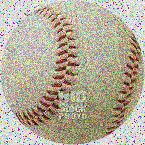

Naš napovedan razred: dishrag, dishcloth 
Algoritem to trdi z zagotovostvjo 18.86%


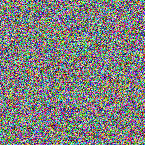

Naš napovedan razred: poncho 
Algoritem to trdi z zagotovostvjo 19.29%


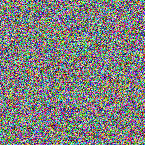

Naš napovedan razred: poncho 
Algoritem to trdi z zagotovostvjo 19.29%


In [ ]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

class TestBenchmark(Benchmark):

    def __init__(self, iskanje, odResitev, prvic, alexnet, benchmarkPrejsnji, najboljsiNiaPY):
        self.Lower = 0
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanje = iskanje
        self.odResitev = odResitev
        self.prvic = prvic
        self.benchmarkPrejsnji = benchmarkPrejsnji
        self.najboljsiNiaPY = najboljsiNiaPY

        self.alexnet = alexnet
    def function(self):
        def evaluate(D, solution):
            razlika = 0 # BenchMark rezultat
            treshold = 0.25 # Dovoljeno odstopanje pikslov

            global prvic # Sprememba na False
            global odResitev # Spreminjanje arraya - vzamemo napovedane RGB vrednosti, ki so (približno) blizu realnim
            global najboljsiNiaPY # Shrani vrednost najboljše NiaPy napovedi
            global benchmarkPrejsnji # Shrani B.M. za primerjavo napovedi

            for i in range(D):
                razlika = razlika + abs(iskanje[i] - solution[i])

                # Ce smo zagnali prvic, array "odResitev napolnimo z vrednostmi, ne glede na to, kaj so
                if (prvic): 
                    odResitev.fill(0) # Napolnimo z niclami, saj ne napove celotnega arraya --> NoneType error
                    odResitev[i] = solution[i] # Prepisemo napovedane vrednosti
                    prvic = False

                # Če je absolutna razlika piksla manjsa od  dovoljene, ga zamenjamo, vse ostale pobijemo
                if (abs(iskanje[i] - solution[i]) < treshold):
                    odResitev[i] = solution[i]

            razlika = ( 1 - (razlika / D) ) # Delimo absolutno razliko pikslov s številom pisklov - DOBIMO VREDNOST MED 0 - 1
            
            spreminjanjeArraya = imgFROM1d(odResitev, oblika)
            PIL_image = PIL.Image.fromarray(np.uint8(spreminjanjeArraya)).convert('RGB')

            indices, percentage = napovejSlike(PIL_image, alexnet)
            with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
                classes = [i.strip() for i in labels.readlines()]

                results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
                if (str(results[0][0]) != "baseball"):
                  razlika *=  ((results[0][1] / 100)) # Napoved AlexNet - DOBIMO VREDNOST MED 0 - 1
                  #print(razlika)
                else:
                  razlika = 0 # Če se bom sploh približal bejzbolski žogici, bom dopolnil

            if (benchmarkPrejsnji < razlika):
                najboljsiNiaPY = solution
                benchmarkPrejsnji = razlika
                print("Najden boljsi:  ", benchmarkPrejsnji)

            return razlika
        
        return evaluate

if __name__ == "__main__":

    originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol.JPEG') # odpiranje - branje slike

    oblika, iskanje = imgTO1d(originalSlika) # Pretvorba slike v 1d array + njena oblika (x,y,3)

    algoritem = ParticleSwarmAlgorithm(NP=10)

    odResitev = np.empty(len(iskanje), dtype=object) # Prazen array dolžine iskanega - Malo pomoči NiaPy
    najboljsiNiaPY = np.empty(len(iskanje), dtype=object) # Prazen array dolžine iskanega - Najboljši NiaPy približek

    benchmarkPrejsnji = 0 # Primerjava BenchMarkov med iteracijami - če je slabši, prepišemo "najboljsiNiaPY" in "benchmarkPrejsnji"

    prvic = True # Preverjanje, če je algo zagnan prvič

    benchm = TestBenchmark(iskanje=iskanje, odResitev=odResitev, prvic=prvic, alexnet=alexnet, benchmarkPrejsnji=benchmarkPrejsnji, najboljsiNiaPY=najboljsiNiaPY)
    task = StoppingTask(D=len(iskanje),
                        nFES=10,
                        optType=OptimizationType.MAXIMIZATION,
                        benchmark=benchm)

    resitev, fitness = algoritem.run(task=task)

    ##################################################################
    # Različni poizkusi benchmarkov in spreminjanja arrayev - PRIKAZ #
    ##################################################################

    print("Povprečna razlika v barvi piksla: ", (fitness*255)) # Butasta metoda razlike pisklov - DOPOLNI

    # Prikaz in napoved zadnjega "odResitev"
    odResitev = imgFROM1d(odResitev, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(odResitev) # Prikaz slike
    odResitev_image = PIL.Image.fromarray(np.uint8(odResitev)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(odResitev_image, alexnet)) # Izpis napovedi AlexNet

    # Prikaz in napoved najboljse napovedi NiaPy
    najboljsiNiaPY = imgFROM1d(najboljsiNiaPY, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(najboljsiNiaPY) # Prikaz slike
    najboljsiNiaPY_image = PIL.Image.fromarray(np.uint8(najboljsiNiaPY)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(najboljsiNiaPY_image, alexnet)) # Izpis napovedi AlexNet

    # Prikaz koncnega - zadnjega outputa NiaPy 
    resitev = imgFROM1d(resitev, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(resitev) # Prikaz slike
    resitev_image = PIL.Image.fromarray(np.uint8(resitev)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(resitev_image, alexnet)) # Izpis napovedi AlexNet

/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


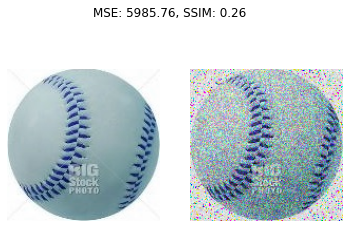

PSNR value is 15.1308 dB
15.130824193669103
0.2591284211626284


In [ ]:
err = compare_images(originalSlika, odResitev)
print(f"PSNR value is %.4f dB" %PSNR(originalSlika, odResitev) )    # resitev odResitev najboljsiNiaPY

from skimage.metrics import peak_signal_noise_ratio as sk_PSNR
print(sk_PSNR(originalSlika, odResitev, data_range=255 ))

#s = ssim(originalSlika, odResitev, multichannel=True)
#print(s)

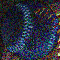

In [ ]:
from PIL import ImageChops
originalSlika_PIL = PIL.Image.open('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol60-60.JPEG')
diff = ImageChops.difference(originalSlika_PIL, odResitev_image)
display(diff)

## BenchMark Fuzzy

Najden boljsi:   0.21309428860212315
1.7901065269250954e-07
BenchMark:  5.7141620848633814e-08


/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


Najden boljsi:   0.21663125962697705
1.9195911169470038e-07
BenchMark:  6.23968751514487e-08
1.6318628509535128e-07
BenchMark:  3.839549920591826e-08
2.886600575788853e-07
BenchMark:  6.115231232276344e-08
Najden boljsi:   0.21736511289086835
1.364422735080713e-07
BenchMark:  4.444621216743743e-08
3.9294733376152777e-07
BenchMark:  1.1012357872620021e-07
2.0191262621054442e-07
BenchMark:  6.210630626738187e-08
2.647649196044109e-07
BenchMark:  5.410998209680165e-08
2.850274687718301e-07
BenchMark:  5.166495269515141e-08
Najden boljsi:   0.2756939918784306
1.9578651565450095e-07
BenchMark:  8.098496691778113e-08
2.4821321208406736e-07
BenchMark:  6.256850280393434e-08
1.327551036704438e-07
BenchMark:  4.963445348749727e-08
4.7295812768810606e-07
BenchMark:  1.1250407747868476e-07
2.1045739458082054e-07
BenchMark:  6.31698815635563e-08
2.53710194356286e-07
BenchMark:  7.914692195397123e-08
1.8318130804026872e-07
BenchMark:  4.938030534288514e-08
1.9644400379858776e-07
BenchMark:  5.17721

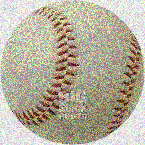

Naš napovedan razred: dishrag, dishcloth 
Algoritem to trdi z zagotovostvjo 20.01%


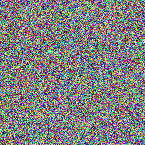

Naš napovedan razred: poncho 
Algoritem to trdi z zagotovostvjo 31.13%


In [ ]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

class TestBenchmark(Benchmark):

    def __init__(self, iskanje, odResitev, prvic, alexnet, benchmarkPrejsnji, najboljsiNiaPY):
        self.Lower = 0
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanje = iskanje
        self.odResitev = odResitev
        self.prvic = prvic
        self.benchmarkPrejsnji = benchmarkPrejsnji
        self.najboljsiNiaPY = najboljsiNiaPY

        self.alexnet = alexnet
    def function(self):
        def evaluate(D, solution):
            razlika = 0 # BenchMark rezultat
            treshold = 0.25 # Dovoljeno odstopanje pikslov

            global prvic # Sprememba na False
            global odResitev # Spreminjanje arraya - vzamemo napovedane RGB vrednosti, ki so (približno) blizu realnim
            global najboljsiNiaPY # Shrani vrednost najboljše NiaPy napovedi
            global benchmarkPrejsnji # Shrani B.M. za primerjavo napovedi

            for i in range(D):
                razlika = razlika + abs(iskanje[i] - solution[i])

                # Ce smo zagnali prvic, array "odResitev napolnimo z vrednostmi, ne glede na to, kaj so
                if (prvic): 
                    odResitev.fill(0) # Napolnimo z niclami, saj ne napove celotnega arraya --> NoneType error
                    odResitev[i] = solution[i] # Prepisemo napovedane vrednosti
                    prvic = False

                # Če je absolutna razlika piksla manjsa od  dovoljene, ga zamenjamo, vse ostale pobijemo
                if (abs(iskanje[i] - solution[i]) < treshold):
                    odResitev[i] = solution[i]

            razlika = ( 1 - (razlika / D) ) # Delimo absolutno razliko pikslov s številom pisklov - DOBIMO VREDNOST MED 0 - 1
            
            spreminjanjeArraya = imgFROM1d(solution, oblika)
            PIL_image = PIL.Image.fromarray(np.uint8(spreminjanjeArraya)).convert('RGB')

            #rezultat = 1

            #rezultat = BenchMark(originalSlika, solution, alexnet, oblika)

            indices, percentage = napovejSlike(PIL_image, alexnet)
            with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
                classes = [i.strip() for i in labels.readlines()]

                results = [(classes[i], percentage[i].item()) for i in indices[0][:1000]]

                ## Not baseball
                #for i in range(len(results)):
                  ##print(str(results[i][0]))
                  #if (str(results[i][0]) == "baseball"):
                    #rezultat *= (results[i][1] / 100)
                    ##print("najden baseball:  ", rezultat)


                if (str(results[0][0]) != "baseball"):
                  razlika *=  ((results[0][1] / 100)) # Napoved AlexNet - DOBIMO VREDNOST MED 0 - 1
                  #print(razlika)
                else:
                  razlika = 0 # Če se bom sploh približal bejzbolski žogici, bom dopolnil

            if (benchmarkPrejsnji < razlika):
                najboljsiNiaPY = solution
                benchmarkPrejsnji = razlika
                print("Najden boljsi:  ", benchmarkPrejsnji)


            # SSIM
            #resitev = imgFROM1d(solution, oblika) # Pretvorba nazaj v sliko
            #rezultat *= ssim(originalSlika, resitev, multichannel=True)
            #print(rezultat)
            # Top other
            #if (str(results[0][0]) != "baseball"):
              #rezultat *= ( results[0][1] / 100 )
            #else:
              #rezultat *= ( results[1][1] / 100 )


            benchmark = BenchMark(originalSlika, solution, alexnet, oblika)
            print("BenchMark: ", benchmark)

            #return razlika
            return benchmark
        
        return evaluate

if __name__ == "__main__":

    originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol.JPEG') # odpiranje - branje slike

    oblika, iskanje = imgTO1d(originalSlika) # Pretvorba slike v 1d array + njena oblika (x,y,3)

    algoritem = ParticleSwarmAlgorithm(NP=100)

    odResitev = np.empty(len(iskanje), dtype=object) # Prazen array dolžine iskanega - Malo pomoči NiaPy
    najboljsiNiaPY = np.empty(len(iskanje), dtype=object) # Prazen array dolžine iskanega - Najboljši NiaPy približek

    benchmarkPrejsnji = 0 # Primerjava BenchMarkov med iteracijami - če je slabši, prepišemo "najboljsiNiaPY" in "benchmarkPrejsnji"

    prvic = True # Preverjanje, če je algo zagnan prvič

    benchm = TestBenchmark(iskanje=iskanje, odResitev=odResitev, prvic=prvic, alexnet=alexnet, benchmarkPrejsnji=benchmarkPrejsnji, najboljsiNiaPY=najboljsiNiaPY)
    task = StoppingTask(D=len(iskanje),
                        nFES=1000,
                        optType=OptimizationType.MAXIMIZATION,
                        benchmark=benchm)

    resitev, fitness = algoritem.run(task=task)

    

    print("Povprečna razlika v barvi piksla: ", (fitness*255)) # Butasta metoda razlike pisklov - DOPOLNI

    # Prikaz in napoved zadnjega "odResitev"
    odResitev = imgFROM1d(odResitev, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(odResitev) # Prikaz slike
    odResitev_image = PIL.Image.fromarray(np.uint8(odResitev)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(odResitev_image, alexnet)) # Izpis napovedi AlexNet

    # Prikaz koncnega - zadnjega outputa NiaPy 
    resitev = imgFROM1d(resitev, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(resitev) # Prikaz slike
    resitev_image = PIL.Image.fromarray(np.uint8(resitev)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(resitev_image, alexnet)) # Izpis napovedi AlexNet

## BenchMark Fuzzy Popucan

/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


ssim:   0.010339391578864989      ntbsbl: 0.9999403733247891      topother:   0.15247188568115233
BenchMark:  0.0015763725313675573
ssim:   0.006406724096693048      ntbsbl: 0.9999640663480386      topother:   0.23090412139892577
BenchMark:  0.001479285840539526
ssim:   0.0026111603528595566      ntbsbl: 0.9999475754424929      topother:   0.19682024002075196
BenchMark:  0.0005139022648712023
ssim:   0.007854118020694651      ntbsbl: 0.9999691325146705      topother:   0.27347862243652343
BenchMark:  0.0021478670754514514
ssim:   0.00789300714649096      ntbsbl: 0.9999732468347066      topother:   0.31885030746459964
BenchMark:  0.0025166204261154105
ssim:   0.009257083770620112      ntbsbl: 0.999969917575363      topother:   0.25252756118774417
BenchMark:  0.0023375984655601935
ssim:   -0.00030339559748236564      ntbsbl: 0.999982210455928      topother:   0.27402677536010744
BenchMark:  -8.313703824022932e-05
ssim:   0.008319771664132902      ntbsbl: 0.9999731791648082      topother:

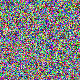

Naš napovedan razred: dishrag, dishcloth 
Algoritem to trdi z zagotovostvjo 31.89%


In [ ]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

class TestBenchmark(Benchmark):

    def __init__(self, iskanje, odResitev, prvic, alexnet, benchmarkPrejsnji, najboljsiNiaPY):
        self.Lower = 0
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanje = iskanje
        self.odResitev = odResitev
        self.prvic = prvic
        self.benchmarkPrejsnji = benchmarkPrejsnji
        self.najboljsiNiaPY = najboljsiNiaPY

        self.alexnet = alexnet
    def function(self):
        def evaluate(D, solution):
            benchmark = 0 # BenchMark rezultat

            benchmark = BenchMarkIzpisuj(originalSlika, solution, alexnet, oblika)
            print("BenchMark: ", benchmark)

            return benchmark
        
        return evaluate

if __name__ == "__main__":

    originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol80-80.JPEG') # odpiranje - branje slike

    oblika, iskanje = imgTO1d(originalSlika) # Pretvorba slike v 1d array + njena oblika (x,y,3)

    algoritem = ParticleSwarmAlgorithm(NP=10)

    odResitev = np.empty(len(iskanje), dtype=object) # Prazen array dolžine iskanega - Malo pomoči NiaPy
    najboljsiNiaPY = np.empty(len(iskanje), dtype=object) # Prazen array dolžine iskanega - Najboljši NiaPy približek

    benchmarkPrejsnji = 0 # Primerjava BenchMarkov med iteracijami - če je slabši, prepišemo "najboljsiNiaPY" in "benchmarkPrejsnji"

    prvic = True # Preverjanje, če je algo zagnan prvič

    benchm = TestBenchmark(iskanje=iskanje, odResitev=odResitev, prvic=prvic, alexnet=alexnet, benchmarkPrejsnji=benchmarkPrejsnji, najboljsiNiaPY=najboljsiNiaPY)
    task = StoppingTask(D=len(iskanje),
                        nFES=10,
                        optType=OptimizationType.MAXIMIZATION,
                        benchmark=benchm)

    resitev, fitness = algoritem.run(task=task)

    # Prikaz koncnega - zadnjega outputa NiaPy 
    resitev = imgFROM1d(resitev, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(resitev) # Prikaz slike
    resitev_image = PIL.Image.fromarray(np.uint8(resitev)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(resitev_image, alexnet)) # Izpis napovedi AlexNet

# Pygad - za import

In [50]:
!pip install pygad

# PyGad Funkcije in importi - za import

In [51]:
import pygad

import itertools
import functools
import operator
import random

def imgTO1dGari(img):
    oblika = img.shape # Shramba shapea slike v "oblika"
    #img = img.reshape((1, -1)) # Pretvorba v 1d array
    img = img.reshape(-1)
    img = np.divide(img, 255) # Standardizacija - deljenje z 255
    img = img.astype(numpy.float) # pretvorba v float (manj decimalk(8), bistveno hitreje deluje)
    return oblika, img

def imgFROM1dGari(img, oblika):
    img = asarray(img) # Pretvorba v pravilen type
    img = img.reshape(oblika) # pretvorba nazaj v prvotno obliko
    # Pri PyGad ne množimo nazaj z 255, saj plt.imshow(result) prikazuje vrednosti pikslov med 0-1
    return img

def fitness_fun(solution, solution_idx): # Fitness Funkcija, ki kliče moj Benchmark, ker lahko prejme samo 2 parametra
    #fitness = fitness_default_absolute_benchmark(solution)
    #fitness = fitness_RMS(solution)
    #fitness = fitness_SSIM(solution)
    fitness = fitness_PearsonCoefCorelation(solution)

    global stevec # global, da jo lahko spreminjam
    global meja # global, da jo lahko spreminjam
    global mejaBool # global, da jo lahko spreminjam

    """
    Ko smo preko meje, za katero mislimo, da bo reprodukcija slike dovolj dobra
    Pogledamo, če je mejaBool False
    Naredimo napoved z AlexNet nad trenutnim solutionom
    Le če je pravilen, ga vključimo v BenchMark
    S tem dosežemo krajšanje časa izvajanja, saj se za vsak sol_per_pop * num_generations nato kliče AlexNet
    """
    if (mejaBool == False): # Ko smo preko meje
      if (stevec > meja):
          solutionSpremenjen = imgFROM1d(solution, oblika) # pretvorba iz 1d array v sliko
          PIL_image_solution = PIL.Image.fromarray(np.uint8(solutionSpremenjen)).convert('RGB')
          napoved = napovedString(PIL_image_solution, alexnet) # Napoved ki vrne samo string kategorije
          print("?VKLOP AlexNet v BenchMark?: " , napoved, stevec , meja )
          if (str(napoved) != dejanska_kategorija): # Ali je napoved nepravilna? Povečaj mejo // pri sol_per_pop=50 je to 50*10 klicev AlexNeta manj
              meja += 10
          if (str(napoved) == dejanska_kategorija): # Ali je napoved pravilna? Izpolni pogoj za vključitev AlexNeta
              mejaBool = True 
    
    if ( (stevec > meja) & (mejaBool == True) ): # Ko smo preko meje in je pogoj izpolnjen, kliči AlexNet BenchMark
      fitness *= BenchMarkGari(solution, solution_idx,alexnet, oblika, dejanska_kategorija) # Vrne fitness_alexnet_top_other float - prepricanost alexneta v top nepravinlo napoved
    
    if (solution_idx == 1): # solution_idx se loopa od 0 do sol_per_pop
      stevec += 1 # Za vsako polno generacijo povecaj stevec
      if ((stevec % 100) == 0 ): # Vsakih 100 rund izpis
          print("Nova runda: " + str(stevec) + " Rezultat: " + str(fitness))

    # Preprečitev padca benchmarka
    if (mejaBool == False):      
      fitness *= 0.5
    else:
      fitness = (fitness * 0.5) + 0.5

    return fitness

def BenchMarkGari (solution, solution_idx,alexnet, oblika, dejanska_kategorija):
    fitness_alexnet_top_other = 1 # Fuzzy - top = 1, mnozenje z 1 prav tako ničesar ne spremeni, inicializacija

    solutionSpremenjen = imgFROM1d(solution, oblika) # Pretvorba iz 1d v array z obliko slike ( visina*sirina*depth)
    PIL_image_solution = PIL.Image.fromarray(np.uint8(solutionSpremenjen)).convert('RGB') # Pretvorba v PIL sliko, za AlexNet
    # Napoved AlexNet
    indices, percentage = napovejSlike(PIL_image_solution, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]
        results = [(classes[i], percentage[i].item()) for i in indices[0][:2]] # POZOR - zaradi hitrosti shranimo samo top DVE napovedi
        napoved = ('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')
        
    # Top other - prisili napoved v prvo kategorijo, ki jo alexnet poda v enotskem vektorju
    if (str(results[0][0]) != dejanska_kategorija): # Če prva ni pravilno napovedana
      fitness_alexnet_top_other *= ( results[0][1] / 100 )
    else:                                           # Če prva je, sigurno druga ni - if deluje hitreje kot fors
      fitness_alexnet_top_other *= ( results[1][1] / 100 )

    if (solution_idx == 20): # Vsake tolko izpis, da lahko spremljamo
        if ((stevec % 10) == 0 ):
            print(str(napoved) + " Runda: " + str(stevec) + " Fitness: " + str(fitness_alexnet_top_other))

    return fitness_alexnet_top_other

def fitness_default_absolute_benchmark(solution): # Fitness Funkcija, ki kliče moj Benchmark, ker lahko prejme samo 2 parametra
    fitness = 1
    fitness = numpy.sum(numpy.abs(iskanjeSlika-solution)) # Absolutna razlika v pikslih - default BenchMark
    fitness = ( (fitness / len(solution)) ) # Pretvorba vrednost med 0 in 1 po vzoru Fuzzy 
    fitness = ( 1 - fitness) # negacija vrednosti
    return fitness

def fitness_geometrical_mean (solution):
  fitness = 1
  fitness = np.prod(np.power(numpy.abs(iskanjeSlika-solution), (1/(len(solution)))))
  fitness = ( 1 - fitness) # negacija vrednosti
  return fitness

def fitness_RMS (solution):
  fitness = 1
  fitness = numpy.sum(numpy.square(numpy.abs(iskanjeSlika-solution)))
  fitness = ( (fitness / len(solution)) ) # Pretvorba vrednost med 0 in 1 po vzoru Fuzzy 
  fitness = numpy.sqrt(fitness)
  fitness = ( 1 - fitness) # negacija vrednosti
  return fitness

def fitness_SSIM (solution):
  fitness = 1
  solution = imgFROM1d(solution, oblika) # Pretvorba nazaj v sliko
  fitness = ssim(originalSlika, solution, multichannel=True)
  return fitness

# Pearson correlation coefficient
def fitness_PearsonCoefCorelation (solution):
  fitness = 1
  fitness = stats.pearsonr(solution, iskanjeSlika)[0]
  fitness = ( (fitness/2) + 0.5) # (da so vrednosti med 0 in1 namesto med -1 in 1)
  return fitness


# PyGad popucan

Nova runda: 100 Rezultat: 0.5286460748111949
Nova runda: 200 Rezultat: 0.5373545324036307
Nova runda: 300 Rezultat: 0.5456254068980021
Nova runda: 400 Rezultat: 0.554243863622145
Nova runda: 500 Rezultat: 0.5631216617628426
Nova runda: 600 Rezultat: 0.5713969217371637
Nova runda: 700 Rezultat: 0.5795249584667082
Nova runda: 800 Rezultat: 0.5870537826013337
Nova runda: 900 Rezultat: 0.5952237303627561
Nova runda: 1000 Rezultat: 0.6032164087268349
Nova runda: 1100 Rezultat: 0.6118134950141367
Nova runda: 1200 Rezultat: 0.6198412599542495
Nova runda: 1300 Rezultat: 0.6275212231188696
Nova runda: 1400 Rezultat: 0.6350947614872936
Nova runda: 1500 Rezultat: 0.6424814994029995
Nova runda: 1600 Rezultat: 0.649638874112983
Nova runda: 1700 Rezultat: 0.6566033227931952
Nova runda: 1800 Rezultat: 0.6636244059109375
Nova runda: 1900 Rezultat: 0.6703250779066012
Nova runda: 2000 Rezultat: 0.6765243428075944
Nova runda: 2100 Rezultat: 0.6837194418176282
Nova runda: 2200 Rezultat: 0.6903751391175463

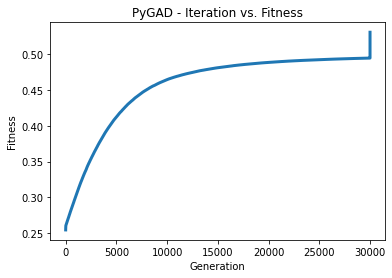

Fitness value of the best solution = 0.5302739677333781
Index of the best solution : 46
Best fitness value reached after 30000 generations.


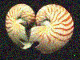

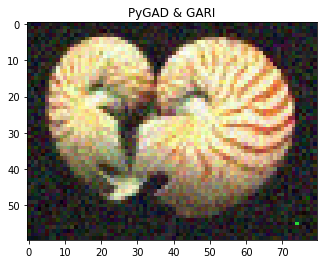

/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


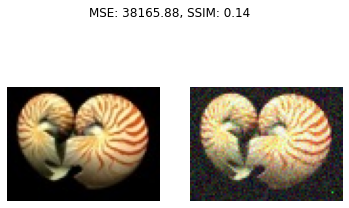

PSNR value is 7.0853 dB


In [44]:
dejanska_kategorija = "chambered nautilus, pearly nautilus, nautilus" # kaj je dejansko na sliki? # SPREMEMBA SLIKE - SPREMEMBA STRINGA!
stevec = 0 # Števec rund, pogoji za izpis...
meja = 30000 # Meja, kdaj začnemo preverjat, če AlexNet že prepozna kaj je na sliki
mejaBool = False  # Če Alexnet pravilno napove, nastavimo na True, ga vklopimo v BenchMark

originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/nautlius80-60.JPEG') # Branje slike # SPREMEMBA SLIKE - SPREMEMBA STRINGA!
oblika, iskanjeSlika = imgTO1dGari(originalSlika) # Pretvorba slike v 1d array + shramba njene oblike(shape) 

zmnozek_oblika = numpy.prod(oblika)

ga_instance = pygad.GA(num_generations=30000, # nekje med 20 in 30k so slike alexnetu prvic prepoznavne
                       num_parents_mating=20, #20
                       fitness_func=fitness_fun,
                       sol_per_pop=50, #50
                       num_genes=int(zmnozek_oblika), # int64 ne gre, pretvorba z int()
                       init_range_low=0.0,
                       init_range_high=1.0,
                       mutation_percent_genes=0.01, # Mutacija 1 / 2 pikslov (odvisno od velikosti)
                       mutation_type="random",
                       mutation_by_replacement=True,
                       random_mutation_min_val=0.0,
                       random_mutation_max_val=1.0)

ga_instance.run() # Zagon

ga_instance.plot_result() # Izris grafa z matplotlib

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution() # Iz najboljse resitve poberemo array, fitness in njen index
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness)) 
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

result = imgFROM1dGari(solution, oblika) # Pretvorba nazaj v sliko

cv2_imshow(result*255) # prikaz slike z OpenCV

result = result[:,:,::-1] # Obrni barve BGR  --> RGB 
plt.imshow(result)
plt.title("PyGAD & GARI")
plt.show()

originalSlika = originalSlika[:,:,::-1]
err = compare_images(originalSlika, result)
print(f"PSNR value is %.4f dB" %PSNR(originalSlika, result) ) # resitev odResitev najboljsiNiaPY

# Prvi Gary - prvi obetaven rezultat
* meja - 20.000
* sledil benchmark (z AlexNet)
* ponovitev do 30500
* čas izvajanja par ur - maximiziranje podobnosti

Prva koda, namenoma nedotaknjena, zakomentirana.. to je prvi uspeli poskus

Streaming output truncated to the last 5000 lines.
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.9

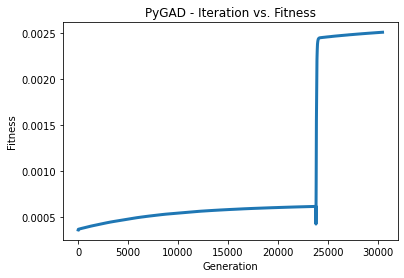

Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z zagotovostvjo 99.97%
Naš napovedan razred: bib 
Algoritem to trdi z z

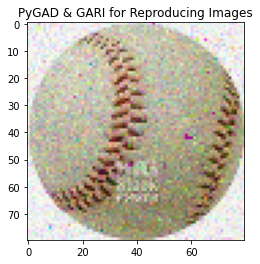

In [ ]:
import pygad

import imageio
import numpy
import itertools
import functools
import operator
import random

target_im = imageio.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol80-80.JPEG')
target_im = numpy.asarray(target_im/255, dtype=numpy.float)

def img2chromosome(img_arr):
    """
    First step in GA is to represent/encode the input as a sequence of characters.
    The encoding used is value encoding by giving each gene in the 
    chromosome its actual value in the image.
    Image is converted into a chromosome by reshaping it as a single row vector.
    """
    chromosome = numpy.reshape(a=img_arr, 
                               newshape=(functools.reduce(operator.mul, 
                                                          img_arr.shape)))
    return chromosome

target_chromosome = img2chromosome(target_im)

def imgFROM1d(testko, oblika):
    testkoDva = numpy.multiply(testko, 255)  
    testkoDva = asarray(testkoDva)
    testkoDva = testkoDva.reshape(oblika)
    return testkoDva

def fitness_fun(solution, solution_idx):
    fitness = numpy.sum(numpy.abs(target_chromosome-solution))
    # Negating the fitness value to make it increasing rather than decreasing.
    fitness = numpy.sum(target_chromosome) - fitness

    fitness = ( (fitness / len(solution)) / 255 )
    global testko
    global meja
    global mejaBool
    if (testko > meja):
      if (mejaBool == False):
          solutionSpremenjen = imgFROM1d(solution, oblika)
          PIL_image_solution = PIL.Image.fromarray(np.uint8(solutionSpremenjen)).convert('RGB')
          #napoved = napovedInPrikaz(PIL_image_solution, alexnet)
          napoved = napovedString(PIL_image_solution, alexnet)
          print("POGOJ: " , testko , meja , napoved)
          if (str(napoved) != "baseball"):
              meja += 10
          if (str(napoved) == "baseball"):
              mejaBool = True

    if ( (testko > meja) & (mejaBool == True) ):
      fitness *= BenchMarkGari(originalSlika, solution, solution_idx,alexnet, oblika)

    else:
      fitness *= 0.25
    
    if (solution_idx == 1):
      testko += 1
      #print("Nova runda: " + str(testko) + " Rezultat: " + str(fitness))

    return fitness

testko = 0
meja = 20000
mejaBool = False

def BenchMarkGari (originalSlika, solution, solution_idx,alexnet, oblika):
  rezultat = 1

  solutionSpremenjen = imgFROM1d(solution, oblika)
  PIL_image_solution = PIL.Image.fromarray(np.uint8(solutionSpremenjen)).convert('RGB')

  indices, percentage = napovejSlike(PIL_image_solution, alexnet)
  with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
      classes = [i.strip() for i in labels.readlines()]
      results = [(classes[i], percentage[i].item()) for i in indices[0][:2]]
      napoved = ('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')
      print(napoved)
      # Not baseball
      #for i in range(len(results)):
          #if (str(results[i][0]) == "baseball"):
              #rezultat *= (1 - (results[i][1] / 100) )
              #print("najden baseball:  ", rezultat)
              #break

  # SSIM
  #rezultat *= ssim(originalSlika, solutionSpremenjen, multichannel=True)

  # MSE
  #rezultat = -MSE(originalSlika, solutionSpremenjen)

  # Top other
  if (str(results[0][0]) != "baseball"):
    rezultat *= ( results[0][1] / 100 )
  else:
    rezultat *= ( results[1][1] / 100 )

  #if (solution_idx == 1):
    #testko += 1
    #print("Nova runda: " + str(testko) + "Rezultat: " + str(rezultat))
  #print(solution_idx)

  return rezultat

import pygad

ga_instance = pygad.GA(num_generations=22500,
                       num_parents_mating=20, #20
                       fitness_func=fitness_fun,
                       sol_per_pop=50, #50
                       num_genes=target_im.size,
                       init_range_low=0.0,
                       init_range_high=1.0,
                       mutation_percent_genes=0.01,
                       mutation_type="random",
                       mutation_by_replacement=True,
                       random_mutation_min_val=0.0,
                       random_mutation_max_val=1.0)

ga_instance.run()

ga_instance.plot_result()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

def chromosome2img(chromosome, img_shape):
    """
    First step in GA is to represent the input in a sequence of characters.
    The encoding used is value encoding by giving each gene in the chromosome 
    its actual value.
    """
    img_arr = numpy.reshape(a=chromosome, newshape=img_shape)
    return img_arr

result = chromosome2img(solution, target_im.shape)
plt.imshow(result)
plt.title("PyGAD & GARI for Reproducing Images")
plt.show()